### Logistic Regression
- Estimates the probability of an event occurring based on independent variables
- Models a binary outcome (True/False, Yes/No)
    - In this example, the outcome is either win or loss
- Equation: $$ f(x) = {e^{b} \over (1+e^{-x})} $$

### Prerequisite:
- Download Anaconda (https://www.anaconda.com/download)
- Install Github (https://gitforwindows.org/) (optional)
- Set up Github account (optional)
- Clone repository (git clone https://github.com/Krescenskok/DataScienceSessions.git) (optional)
- Useful git commands (https://git-scm.com/docs)

### Problem Statement and Hypothesis
- Research Question: Can the business predict opportunity outcomes?
- Alternate Hypothesis: Yes, we can predict opportunity outcomes
- Null Hypothesis: No, we cannot predict opportunity outcomes

### Why is it important to predict an opportunity with statistical significance?
- Anticipate sales for CST and other leadership
- Help influence a positive behavior


**Expected Outcome:** To have a model that can generalize trends in data using significant variables to predict a win or a loss.
- Understand which opportunity variables are most significant
- Figure out the accuracy of the model

**Data Collection Concerns:**
- Dataset needs to have at least 10,000 records to prevent bias
- At least 10 variables 
- At least 1 continuous and 1 categorical variable
- Rights to use the data

**Data Variables:**
- **Independent (x<sub>1</sub>-x<sub>n</sub>):** All other variables
- **Dependent (Y):** Stage (Categorical variable - Outcomes are only win or loss)
    - Logistic regressions are used to predict categorical outcomes

**Packages:**
- **pandas:** Used for dataframes
- **pyodbc:** Used to connect to SQL Server
- **sklearn/stats model API:** Used for our logistic model
    - Create train and test sets
    - Recursive feature elimination
    - Accuracy/precision/matrix scores
    - Receiver operator characteristic
- **seaborn/matplotlib:** Used for visualization

**Preprocessing Technique:**
- Import packages and load data
- Review the data
    - head(), info()
    - Handle missingness, outliers
- Exploratory analysis
- Variable selection

### Import Packages and load data

In [2]:
#import packages
import pyodbc as db
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#connect to DB
server = 'tcp:usaepwvds025.database.windows.net' 
database = 'SIMS' 
username = 'ciaserviceaccount' 
password = 'pipeline$330' 
cnxn = db.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

#load dataframe
sql = "select * from sims.logisticRegression"
df = pd.read_sql(sql,cnxn)


OperationalError: ('08001', '[08001] [Microsoft][ODBC Driver 17 for SQL Server]TCP Provider: The wait operation timed out.\r\n (258) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Login timeout expired (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]A network-related or instance-specific error has occurred while establishing a connection to SQL Server. Server is not found or not accessible. Check if instance name is correct and if SQL Server is configured to allow remote connections. For more information see SQL Server Books Online. (258)')

### Review the data
- Understand data types (Continuous vs Categorical)
- Investigate missingness
- Scale
- Outliers

In [ ]:
df.head()

In [ ]:
df.info()

#### Drop ID Columns
- Looking for patterns in the data. Since the ID columns are unique, this won't help us in predicting our win/loss opportunities

In [ ]:
df = df.drop(columns=['LegacyAccountID', 'CurrentCompanyID', 'OpportunityID'])

We can't impute comments, so we will drop `CloseComments` from our dataset

In [ ]:
df = df.drop(columns = 'CloseComments')

Since we have `CreateDate` that have no null values, we will use this column and drop `StartDate`

In [ ]:
df = df.drop(columns = 'StartDate')

In [ ]:
df.query('LegacyAccountName != LegacyAccountName')

In [ ]:
df.dropna(subset=['LegacyAccountName'], inplace=True)

Impute a value for missing market caps
- Average value in the market cap category
- Some companies don't have a market cap category, so we will first impute market cap categories

In [ ]:
modeMarketCap = df['CurrentCompanyMarketCapCategory'].mode()
print(modeMarketCap)
df['CurrentCompanyMarketCapCategory'].fillna(df['CurrentCompanyMarketCapCategory'].mode()[0], inplace=True)

In [ ]:
meanMarketCap = df.groupby('CurrentCompanyMarketCapCategory')['CurrentCompanyMarketCap'].mean().reset_index()
print(meanMarketCap)
totalMeanMarketCap = df['CurrentCompanyMarketCap'].mean()
print(totalMeanMarketCap)

In [ ]:
df['CurrentCompanyMarketCap'] = df['CurrentCompanyMarketCap'].fillna(df.groupby('CurrentCompanyMarketCapCategory')['CurrentCompanyMarketCap'].transform('mean'))

In [ ]:
df['CurrentCompanyMarketCap'].fillna(totalMeanMarketCap, inplace = True)

In [ ]:
df['Top12CMMCompany'].fillna('False', inplace = True)
df['Top24CMMCompany'].fillna('False', inplace = True)

In [ ]:
df.info()

In [ ]:
avgTotalOppAmt = df['TotalOpportunityAmount'].mean()
print(avgTotalOppAmt)
df['TotalOpportunityAmount'].fillna(avgTotalOppAmt, inplace = True)

In [ ]:
CloseReasonMode = df['CloseReason'].mode()
print(CloseReasonMode)

df.loc[(df['CloseReason'].isna()) & (df['StageName'] == "Closed Lost"), 'CloseReason'] = "CloseReasonMode"

df.loc[(df['CloseReason'].isna()) & (df['StageName'] == "Closed Won"), 'CloseReason'] = "Won"


In [1026]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27574 entries, 0 to 27593
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   LegacySFInstance                 27574 non-null  object        
 1   LegacyAccountName                27574 non-null  object        
 2   CurrentCompanyGroup              27574 non-null  object        
 3   CurrentCompanyMarketCap          27574 non-null  float64       
 4   CurrentCompanyMarketCapCategory  27574 non-null  object        
 5   Top12CMMCompany                  27574 non-null  object        
 6   Top24CMMCompany                  27574 non-null  object        
 7   OpportunityName                  27574 non-null  object        
 8   OpportunityType                  27574 non-null  object        
 9   TotalOpportunityAmount           27574 non-null  float64       
 10  CreateDate                       27574 non-null  datetime64[ns]

In [1027]:
df['CreateDateMonth'] = df['CreateDate'].dt.month 

In [1028]:
display(df)

,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,TotalOpportunityAmount,CreateDate,OpportunityOwner,StageName,CloseReason,ImpactedFY,CreateDateMonth
0,RxC,"Coram Speciality Infusion Services, Inc.","Coram Speciality Infusion Services, Inc.",8.918423e+10,Large,False,False,Coram/CVS Copay Finder,New,7.533936e+05,2019-08-06 19:15:55,Andrew Burman,Closed Lost,No Bid,FY 2020,8
1,RxC,Caris-MPI,Caris-MPI,8.918423e+10,Large,False,False,Precision Medicine Survey,New,2.000000e+05,2017-05-31 15:15:14,Jennifer Frytak,Closed Lost,Client Funding Cut,FY 2018,5
2,RxC,Pharma Pac,Pharma Pac,8.918423e+10,Large,False,False,Pharma Pac,New,1.738380e+05,2020-04-09 15:52:13,Ryan Grimmett,Closed Lost,Cancelled,FY 2022,4
3,RxC,Biologics Financial Reconciliation,Biologics Financial Reconciliation,8.918423e+10,Large,False,False,Biologics RARE - Launched for FY22 Tracking,Renewal,4.498679e+07,2021-02-04 14:55:41,Laura Sieve,Closed Won,Won,FY 2022,2
4,RxC,Biologics Financial Reconciliation,Biologics Financial Reconciliation,8.918423e+10,Large,False,False,Biologics ONC - Launched for FY22 Tracking,Renewal,1.808600e+07,2021-04-27 15:01:37,Laura Sieve,Closed Won,Won,FY 2022,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27589,RHP,Biocon Biologics Inc.,Biocon Biologics Inc.,1.332562e+11,Not Available,False,False,Biocon Biologics_TS SOW,New,6.298000e+04,2023-06-14 21:23:02,Laura Redman,Closed Won,Won,FY 2024,6
27590,RHP,Biocon Biologics Inc.,Biocon Biologics Inc.,1.332562e+11,Not Available,False,False,"Biocon Biologics_State Insulin Prog (MN, CO, ME)",New,1.175200e+05,2023-06-29 23:19:29,Laura Redman,Closed Won,Won,FY 2024,6
27591,RHP,Biocon Biologics Inc.,Biocon Biologics Inc.,1.332562e+11,Not Available,False,False,"Biocon Biologics_LS, TS & State Insulin Imp SOW",New,0.000000e+00,2023-06-29 23:25:26,Laura Redman,Closed Won,Won,FY 2024,6
27592,RHP,Biocon Biologics Inc.,Biocon Biologics Inc.,1.332562e+11,Not Available,False,False,"Biocon Biologics_State Insulin Prog (MN, CO, M...",New,0.000000e+00,2024-01-15 17:36:03,Laura Redman,Closed Lost,No Bid,FY 2024,1


## Outliers
- Outliers can skew the results of data analysis and impact model performance
- Handling Outliers: 
    - Remove
    - Impute
    - Scale/Standardize

In [1029]:
df.describe()

,CurrentCompanyMarketCap,TotalOpportunityAmount,CreateDate,CreateDateMonth
count,2.757400e+04,2.757400e+04,27574,27574.000000
mean,1.331619e+11,7.533936e+05,2018-01-14 13:16:28.340828416,6.534271
min,6.493000e+01,-2.800000e+06,2008-03-17 18:16:52,1.000000
25%,1.434807e+10,5.500000e+03,2015-06-24 17:07:37,4.000000
50%,1.174317e+11,8.000000e+04,2018-09-17 22:26:58,7.000000
75%,1.576153e+11,3.208288e+05,2021-03-10 10:28:36.750000128,9.000000
max,6.998863e+11,1.188350e+09,2024-03-04 14:30:36,12.000000
std,1.498762e+11,1.266584e+07,NaN,3.278760


Above, we see that `CreateDateMonth` is a numeric value when we want it to be a categorical value. So, we will convert it to an object type

In [1030]:
df['CreateDateMonth'] = df['CreateDateMonth'].astype('object')

Customizing percentages allows us to view more about the data and decide whether our thoughts about outliers are accurate

In [1031]:
## Customize percentiles
df.describe(percentiles=[.01, .05, .1, .25, .5, .75, .90, .95, .99])  

,CurrentCompanyMarketCap,TotalOpportunityAmount,CreateDate
count,2.757400e+04,2.757400e+04,27574
mean,1.331619e+11,7.533936e+05,2018-01-14 13:16:28.340828416
min,6.493000e+01,-2.800000e+06,2008-03-17 18:16:52
1%,9.376078e+05,0.000000e+00,2008-05-19 20:04:45.240000
5%,1.477488e+08,0.000000e+00,2010-03-11 06:42:28.200000
10%,1.164934e+09,0.000000e+00,2012-01-04 02:23:34.700000
25%,1.434807e+10,5.500000e+03,2015-06-24 17:07:37
50%,1.174317e+11,8.000000e+04,2018-09-17 22:26:58
75%,1.576153e+11,3.208288e+05,2021-03-10 10:28:36.750000128
90%,3.055616e+11,8.024532e+05,2022-09-28 22:35:00.400000


In [1032]:
import seaborn as sb
import statsmodels.api as sm

<Axes: xlabel='CurrentCompanyMarketCap'>

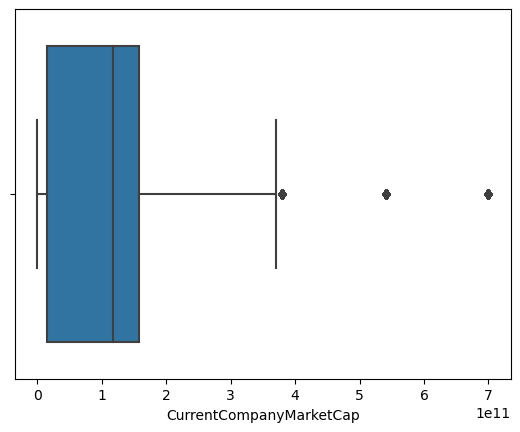

In [1033]:
sb.boxplot(x='CurrentCompanyMarketCap',data=df) 
#Decision: Use min max scalar to scale the data to remove the impactive outliers

## Exploratory Data Analysis
- Data Visualization with `StageName`

<Axes: xlabel='StageName'>

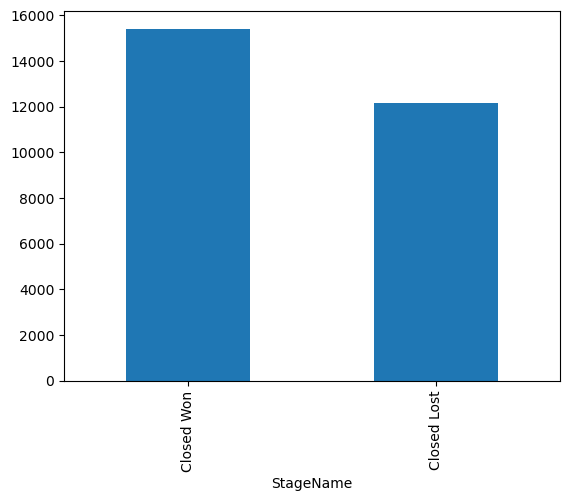

In [1034]:
df['StageName'].value_counts().plot(kind='bar')

In [1035]:
df['StageName'].value_counts()

StageName
Closed Won     15423
Closed Lost    12151
Name: count, dtype: int64

In [1036]:
df['StageName'] = df['StageName'].map({'Closed Won': 1, 'Closed Lost': 0})

winRate = (sum(df['StageName'])/len(df['StageName'].index))*100
print(winRate)

55.93312540799303


In [1037]:
pd.crosstab(df['ImpactedFY'],df['StageName'])

StageName,0,1
ImpactedFY,,
FY 1999,549,0
FY 2005,2,0
FY 2007,0,17
FY 2008,49,276
FY 2009,122,150
FY 2010,212,212
FY 2011,315,242
FY 2012,273,494
FY 2013,468,464


<Axes: title={'center': 'Stage Name vs Impacted Fiscal Year'}, xlabel='ImpactedFY'>

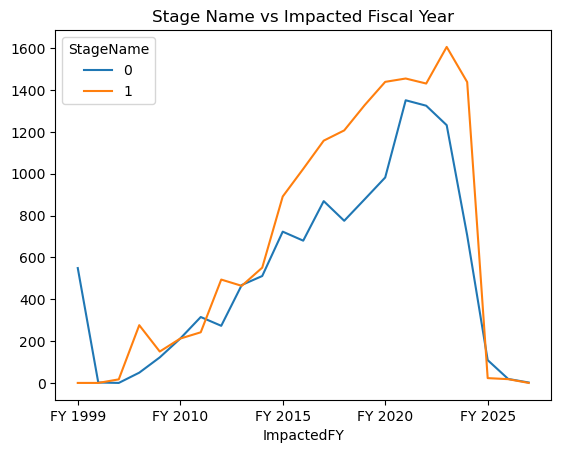

In [1038]:
pd.crosstab(df['ImpactedFY'],df['StageName']).plot(kind='line', title = 'Stage Name vs Impacted Fiscal Year')

<Axes: title={'center': 'Stage Name vs Create Date Month'}, xlabel='CreateDateMonth'>

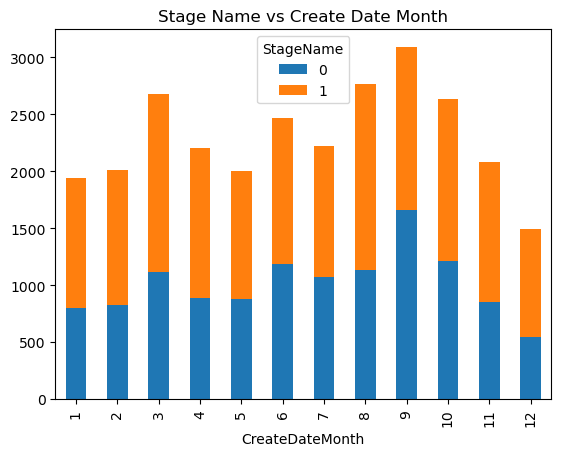

In [1039]:
pd.crosstab(df['CreateDateMonth'],df['StageName']).plot(kind='bar', stacked = True, title = 'Stage Name vs Create Date Month')

- set_index: Allows one or more column values to become the row index. Here, we are using the 'CreateDate' as the new index so we can create a graph against that value
- resample: Typically used for timeseries analysis. It generates a unique sampling distribution on the basis of actual data

In [1040]:
df.head()

,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,TotalOpportunityAmount,CreateDate,OpportunityOwner,StageName,CloseReason,ImpactedFY,CreateDateMonth
0,RxC,"Coram Speciality Infusion Services, Inc.","Coram Speciality Infusion Services, Inc.",8.918423e+10,Large,False,False,Coram/CVS Copay Finder,New,7.533936e+05,2019-08-06 19:15:55,Andrew Burman,0,No Bid,FY 2020,8
1,RxC,Caris-MPI,Caris-MPI,8.918423e+10,Large,False,False,Precision Medicine Survey,New,2.000000e+05,2017-05-31 15:15:14,Jennifer Frytak,0,Client Funding Cut,FY 2018,5
2,RxC,Pharma Pac,Pharma Pac,8.918423e+10,Large,False,False,Pharma Pac,New,1.738380e+05,2020-04-09 15:52:13,Ryan Grimmett,0,Cancelled,FY 2022,4
3,RxC,Biologics Financial Reconciliation,Biologics Financial Reconciliation,8.918423e+10,Large,False,False,Biologics RARE - Launched for FY22 Tracking,Renewal,4.498679e+07,2021-02-04 14:55:41,Laura Sieve,1,Won,FY 2022,2
4,RxC,Biologics Financial Reconciliation,Biologics Financial Reconciliation,8.918423e+10,Large,False,False,Biologics ONC - Launched for FY22 Tracking,Renewal,1.808600e+07,2021-04-27 15:01:37,Laura Sieve,1,Won,FY 2022,4


<Axes: title={'center': 'Total Wins by Create Date'}, xlabel='CreateDate'>

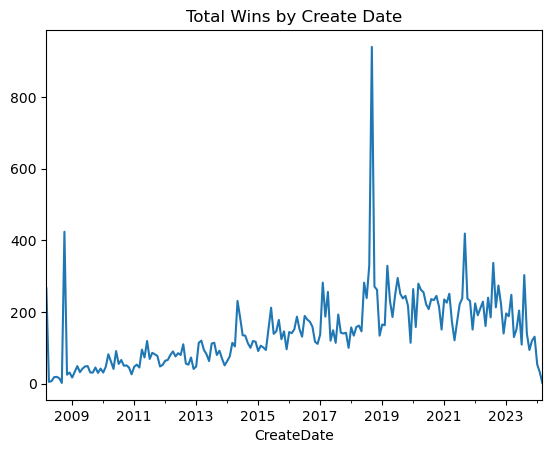

In [1041]:
df.set_index('CreateDate', inplace = True)
df.resample('1M').count()['StageName'].plot(title = 'Total Wins by Create Date')

<Axes: title={'center': 'Stage Name by Legacy SF Instance'}, xlabel='LegacySFInstance'>

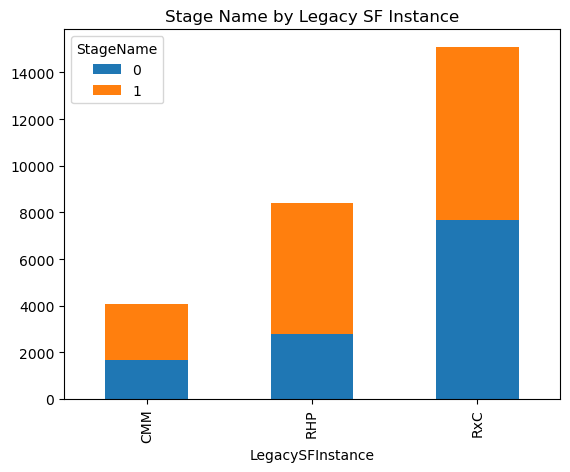

In [1042]:
#compare wins over LegacySFInstance
pd.crosstab(df['LegacySFInstance'],df['StageName']).plot(kind="bar", stacked=True, title = "Stage Name by Legacy SF Instance")

<Axes: title={'center': 'Stage Name by Market Cap Category'}, xlabel='CurrentCompanyMarketCapCategory'>

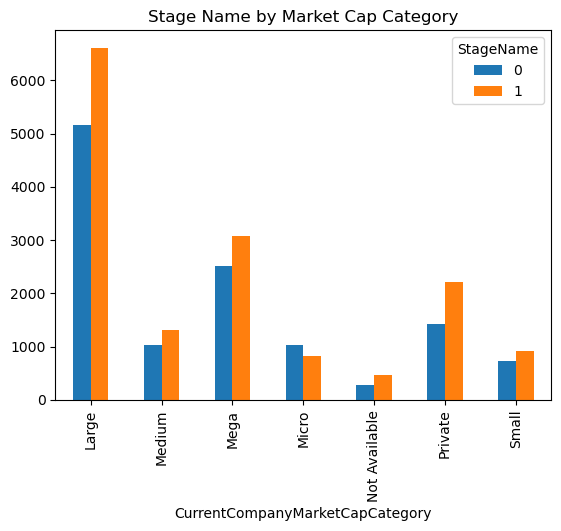

In [1043]:
#compare wins by CurrentCompanyMarketCapCategory
pd.crosstab(df['CurrentCompanyMarketCapCategory'],df['StageName']).plot(kind="bar", stacked=False, title="Stage Name by Market Cap Category")

In [1044]:
df.reset_index('CreateDate', inplace= True)

In [1045]:
df.head()

,CreateDate,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,TotalOpportunityAmount,OpportunityOwner,StageName,CloseReason,ImpactedFY,CreateDateMonth
0,2019-08-06 19:15:55,RxC,"Coram Speciality Infusion Services, Inc.","Coram Speciality Infusion Services, Inc.",8.918423e+10,Large,False,False,Coram/CVS Copay Finder,New,7.533936e+05,Andrew Burman,0,No Bid,FY 2020,8
1,2017-05-31 15:15:14,RxC,Caris-MPI,Caris-MPI,8.918423e+10,Large,False,False,Precision Medicine Survey,New,2.000000e+05,Jennifer Frytak,0,Client Funding Cut,FY 2018,5
2,2020-04-09 15:52:13,RxC,Pharma Pac,Pharma Pac,8.918423e+10,Large,False,False,Pharma Pac,New,1.738380e+05,Ryan Grimmett,0,Cancelled,FY 2022,4
3,2021-02-04 14:55:41,RxC,Biologics Financial Reconciliation,Biologics Financial Reconciliation,8.918423e+10,Large,False,False,Biologics RARE - Launched for FY22 Tracking,Renewal,4.498679e+07,Laura Sieve,1,Won,FY 2022,2
4,2021-04-27 15:01:37,RxC,Biologics Financial Reconciliation,Biologics Financial Reconciliation,8.918423e+10,Large,False,False,Biologics ONC - Launched for FY22 Tracking,Renewal,1.808600e+07,Laura Sieve,1,Won,FY 2022,4


## Encoding
- Model cannot interpret strings, so we need to encode all the variables as numbers
- Drop columns that have too many categories
- Dummy variables
- Curse of dimensionality 

In [1046]:
df.describe()

,CreateDate,CurrentCompanyMarketCap,TotalOpportunityAmount,StageName
count,27574,2.757400e+04,2.757400e+04,27574.000000
mean,2018-01-14 13:16:28.340828416,1.331619e+11,7.533936e+05,0.559331
min,2008-03-17 18:16:52,6.493000e+01,-2.800000e+06,0.000000
25%,2015-06-24 17:07:37,1.434807e+10,5.500000e+03,0.000000
50%,2018-09-17 22:26:58,1.174317e+11,8.000000e+04,1.000000
75%,2021-03-10 10:28:36.750000128,1.576153e+11,3.208288e+05,1.000000
max,2024-03-04 14:30:36,6.998863e+11,1.188350e+09,1.000000
std,NaN,1.498762e+11,1.266584e+07,0.496476


In [1047]:
df.describe(include='object')

,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,OpportunityOwner,CloseReason,ImpactedFY,CreateDateMonth
count,27574,27574,27574,27574,27574,27574,27574,27574,27574,27574,27574,27574
unique,3,1632,921,7,2,2,25890,3,249,76,23,12
top,RxC,"Merck & Co., Inc.",Bristol Myers Squibb,Large,False,False,2016 Mid-America Cancer Symposium,New,Admin User,Won,FY 2023,9
freq,15094,847,1487,11776,17528,23111,36,19555,2532,13408,2838,3090


A decision was made to drop the columns with too many categories, as it would not allow for a generalized model and would not display any patterns in the data. In addition, the `ImpactedFY` was dropped since it would not allow for the prediction of a win or loss of an opportunity in the future years.

In [1048]:
df = df.drop(columns=['LegacyAccountName', 'CurrentCompanyGroup', 'OpportunityName', 'OpportunityOwner', 'CloseReason', 'CreateDate', 'ImpactedFY'])

In [1049]:
#'drop_first' argument is set to true to reduce redundancy and reduce the correlations created with the dummy variables
df = pd.get_dummies(df, columns=["LegacySFInstance", "CurrentCompanyMarketCapCategory", "Top12CMMCompany", "Top24CMMCompany", "OpportunityType", "CreateDateMonth"], prefix=["LegacySFInstance", "CurrentCompanyMarketCapCategory", "Top12CMMCompany", "Top24CMMCompany", "OpportunityType", "CreateDateMonth"], drop_first = True)     

In [1050]:
df.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,StageName,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
0,8.918423e+10,7.533936e+05,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,8.918423e+10,2.000000e+05,0,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,8.918423e+10,1.738380e+05,0,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,8.918423e+10,4.498679e+07,1,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,8.918423e+10,1.808600e+07,1,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [1051]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27574 entries, 0 to 27573
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   CurrentCompanyMarketCap                        27574 non-null  float64
 1   TotalOpportunityAmount                         27574 non-null  float64
 2   StageName                                      27574 non-null  int64  
 3   LegacySFInstance_RHP                           27574 non-null  bool   
 4   LegacySFInstance_RxC                           27574 non-null  bool   
 5   CurrentCompanyMarketCapCategory_Medium         27574 non-null  bool   
 6   CurrentCompanyMarketCapCategory_Mega           27574 non-null  bool   
 7   CurrentCompanyMarketCapCategory_Micro          27574 non-null  bool   
 8   CurrentCompanyMarketCapCategory_Not Available  27574 non-null  bool   
 9   CurrentCompanyMarketCapCategory_Private        275

In [1052]:
df = df.replace({True: 1, False: 0})

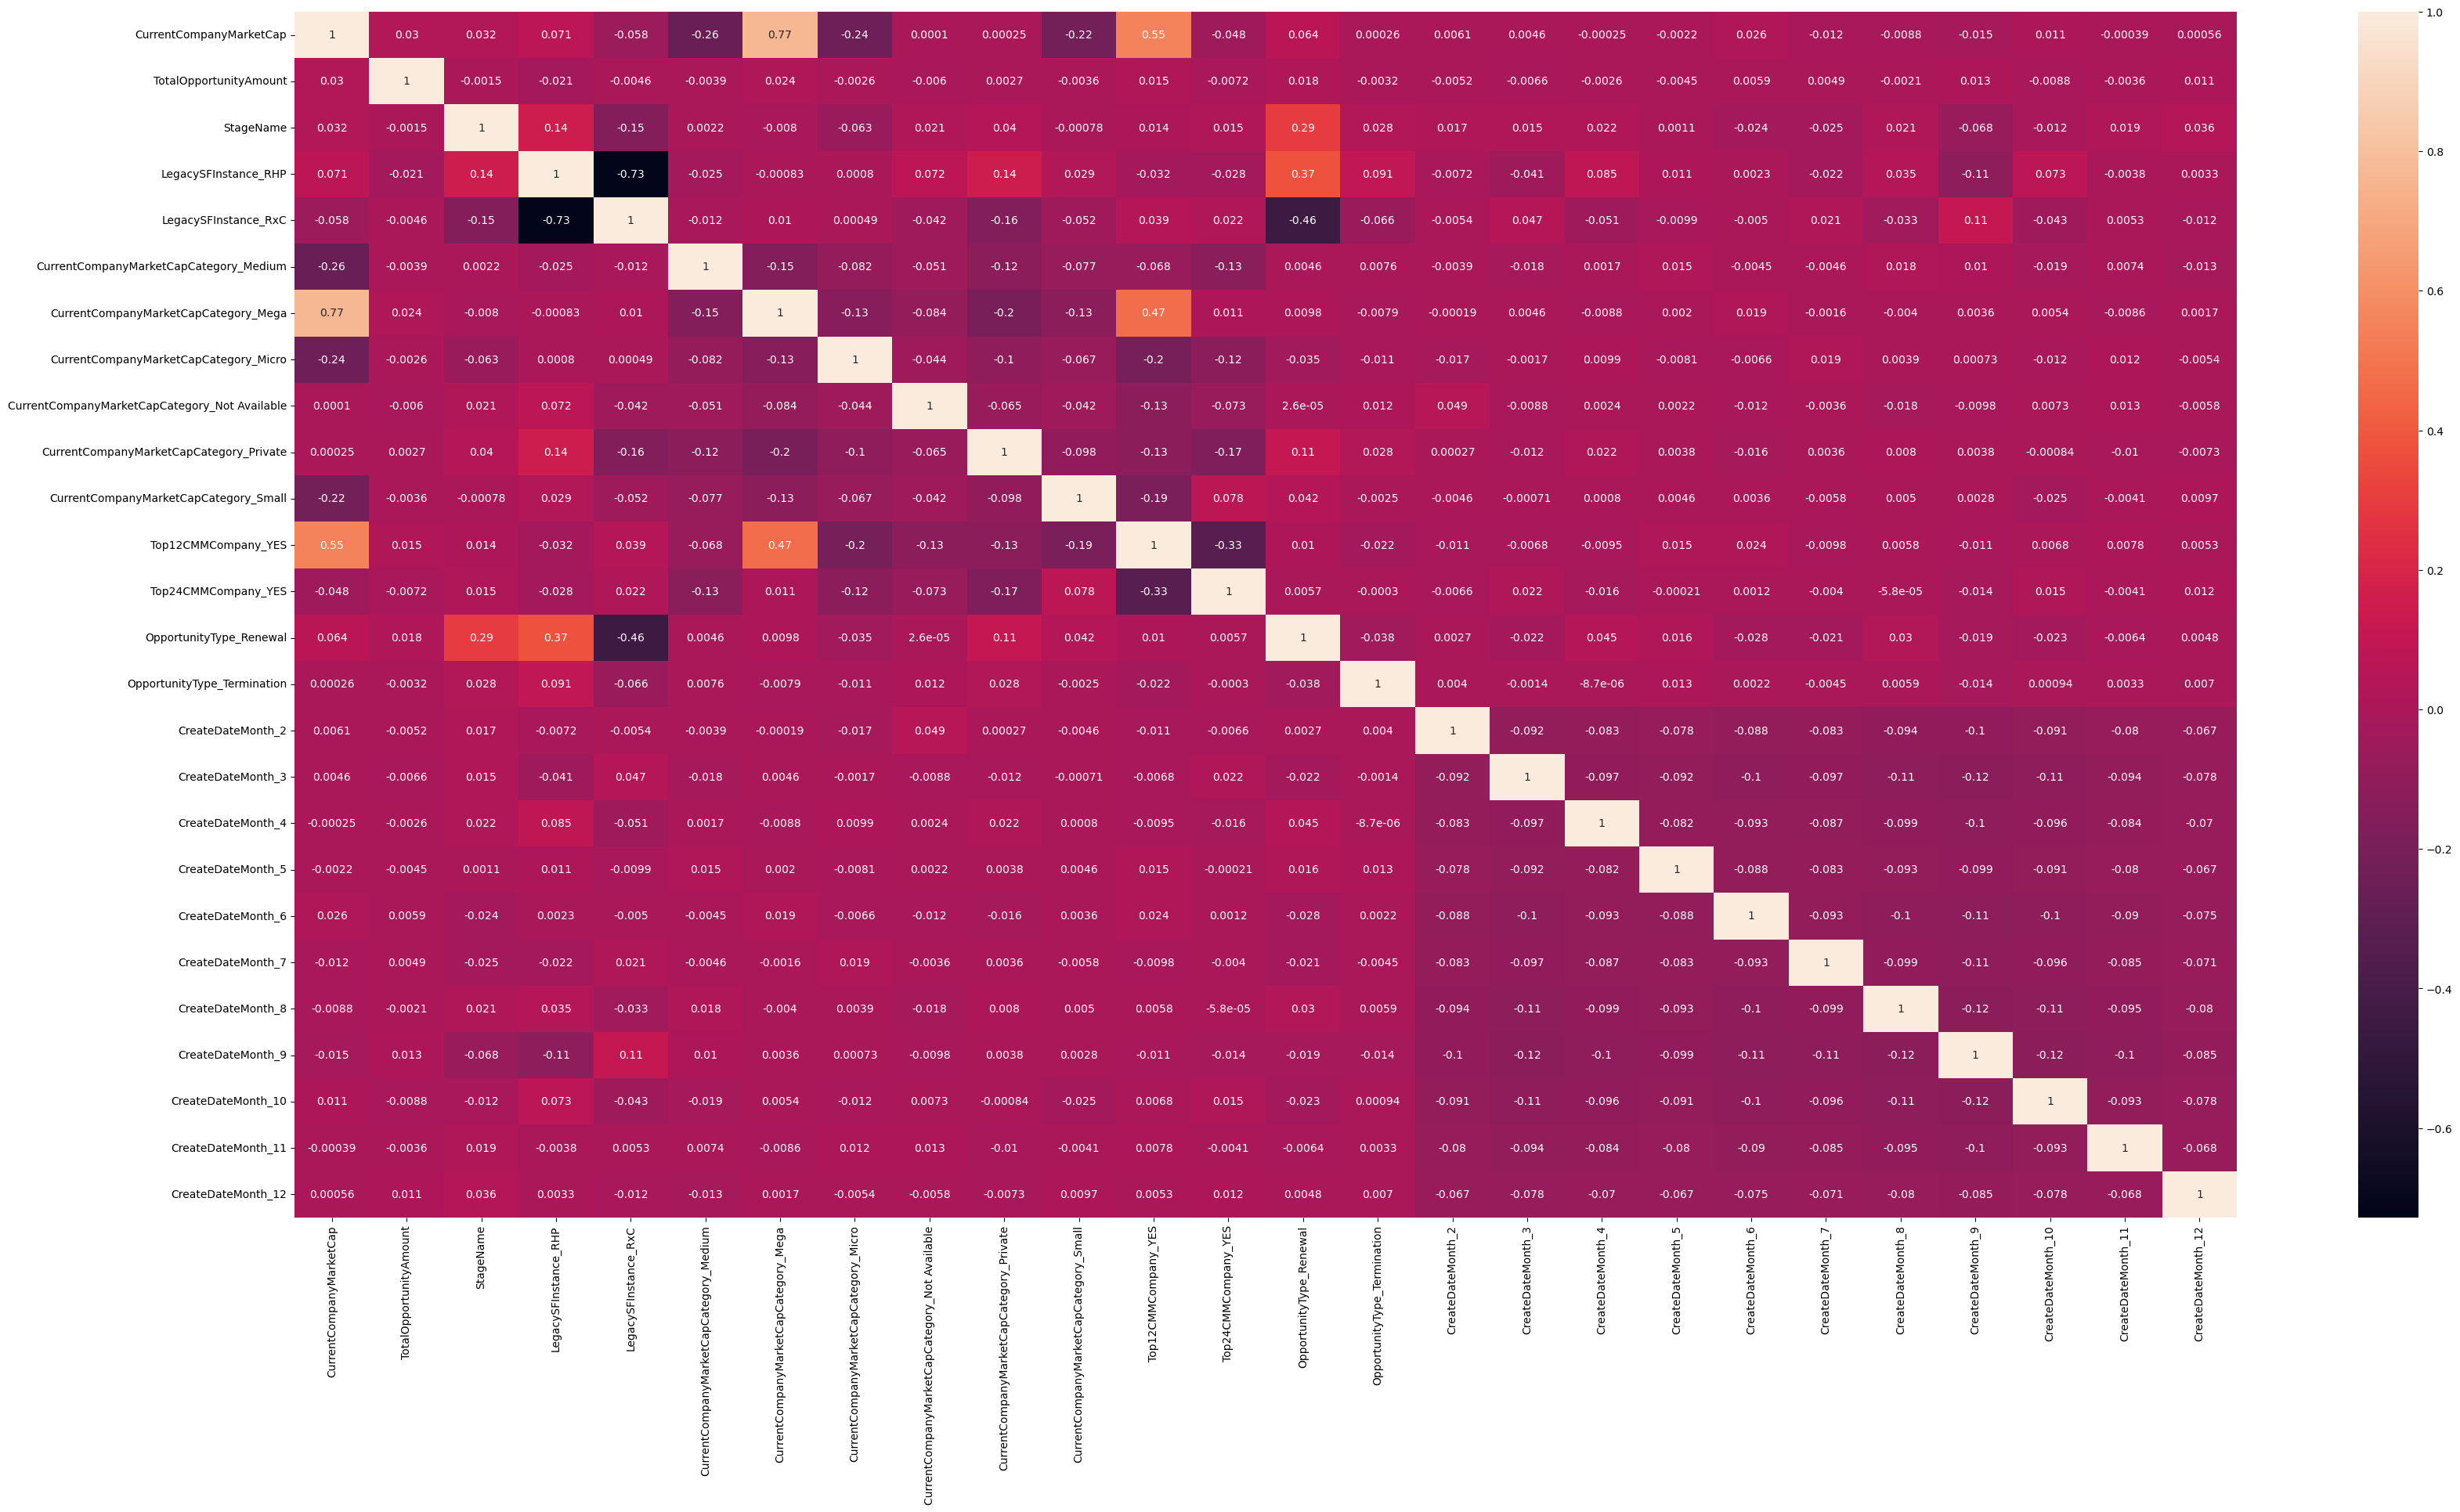

In [1053]:
import matplotlib.pyplot as plt
plt.figure(figsize = (40,20))
sb.heatmap(df.corr(), annot = True)
plt.show()

Since we know there is a correlation between the top 12 and 24 CMM Company variables, we will drop `Top12CMMCompany_YES` from our independent variables

In [1054]:
X = df.drop(['StageName', 'Top12CMMCompany_YES'], axis=1)
y = df['StageName']

### Splitting data into testing and training sets
- 70/30 split

In [1055]:
from sklearn.model_selection import train_test_split #split train and test set
from sklearn.preprocessing import MinMaxScaler #scale features
import numpy as np

In [1056]:
######split data
#split the training and testing sets
 
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
 

In [1057]:
X_train.shape

(19301, 24)

In [1058]:
X_test.shape

(8273, 24)

### Scale the data
When scaling the data, the scaler function returns an array of the values, so we convert it back to a dataframe after the transformation
- Purpose: To remove outliers
- MinMaxScaler(): A form of normalizing data between 0 and 1

In [1059]:
# instantiate the scaler
scaler = MinMaxScaler()

In [1060]:
#scale between 0 and 1 returns array
X_train_array = scaler.fit_transform(X_train)
X_train_array

array([[0.19039694, 0.00247466, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.19039694, 0.00298316, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19039694, 0.00235067, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02898767, 0.0023534 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2719917 , 0.00235361, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04350377, 0.00239265, 0.        , ..., 0.        , 0.        ,
        0.        ]])

Now that we have an array of transformed values, we need to convert it back to a dataframe. When doing so, we can specify the columns and keep the same index from our original training data set.

In [1061]:
print(X_train.columns)

Index(['CurrentCompanyMarketCap', 'TotalOpportunityAmount',
       'LegacySFInstance_RHP', 'LegacySFInstance_RxC',
       'CurrentCompanyMarketCapCategory_Medium',
       'CurrentCompanyMarketCapCategory_Mega',
       'CurrentCompanyMarketCapCategory_Micro',
       'CurrentCompanyMarketCapCategory_Not Available',
       'CurrentCompanyMarketCapCategory_Private',
       'CurrentCompanyMarketCapCategory_Small', 'Top24CMMCompany_YES',
       'OpportunityType_Renewal', 'OpportunityType_Termination',
       'CreateDateMonth_2', 'CreateDateMonth_3', 'CreateDateMonth_4',
       'CreateDateMonth_5', 'CreateDateMonth_6', 'CreateDateMonth_7',
       'CreateDateMonth_8', 'CreateDateMonth_9', 'CreateDateMonth_10',
       'CreateDateMonth_11', 'CreateDateMonth_12'],
      dtype='object')


In [1062]:
print(X_train.index)

Index([24519, 20245,  3465,  5274, 25876, 18834, 17917,   225, 17394, 17588,
       ...
       22258, 20757, 24275,  9225, 21243, 13123, 19648,  9845, 10799,  2732],
      dtype='int64', length=19301)


In [1063]:
#convert back to df
X_train = pd.DataFrame(X_train_array, columns=X_train.columns, index=X_train.index)
X_train

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
24519,0.190397,0.002475,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20245,0.190397,0.002983,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,0.190397,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5274,1.000000,0.002587,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25876,0.306204,0.002477,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.119323,0.002418,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,0.190397,0.002400,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,0.028988,0.002353,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10799,0.271992,0.002354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Any transformations that is done to the training set should also be done to the testing set

In [1064]:
#Scale between 0 and 1 returns array
X_test_array = scaler.transform(X_test)
 
X_test_array

array([[1.90396942e-01, 2.43479039e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.53808675e-01, 2.35066998e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.06204207e-01, 2.45351180e-03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.81346344e-02, 2.35066998e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.01458997e-04, 2.35696642e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.23150249e-01, 2.72360378e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [1065]:
#convert back to df
X_test = pd.DataFrame(X_test_array, columns=X_test.columns, index=X_test.index)
X_test.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
20175,0.190397,0.002435,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6818,0.453809,0.002351,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26318,0.306204,0.002454,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10929,0.271992,0.006542,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5575,1.000000,0.002367,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression Modeling
- Family is set to Binomial since there are only 2 outcomes of the dependent variable (Win or Loss)
- add_constant: Adds a column of 1's to the dataframe to estimate an intercept
- Focus on p (probability) values for feature elimination
- Null Hypothesis: Feature does not affect the `StageName`
- Alternate Hypothesis: Feature does affect the `StageName`
- P-value: How likely the data could have occurred under the null hypothesis
- Any feature that has a p-value less than .05 is statistically significant, and we conclude that the feature does affect the `StageName`

#### Using statsmodel.api allows us to view a summary of the output of the generalized linear model

In [1066]:
import statsmodels.api as sm #logistic regression with summary

In [1067]:
newX = sm.add_constant(X_train)
newX.head()

,const,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
24519,1.0,0.190397,0.002475,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20245,1.0,0.190397,0.002983,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,1.0,0.190397,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5274,1.0,1.000000,0.002587,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25876,1.0,0.306204,0.002477,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1068]:
# Logistic regression model using statsmodels for summary and p values
lm = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                19301
Model:                            GLM   Df Residuals:                    19276
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12211.
Date:                Fri, 08 Mar 2024   Deviance:                       24422.
Time:                        12:42:48   Pearson chi2:                 1.93e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1009
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.1718      0.075     -2.284      0.022      -0.319      -0.024
CurrentCompanyMarketCap                           0.3024      0.129      2.339      0.019       0.049       0.556
TotalOpportunityAmount                           -0.4666      2.086     -0.224      0.823      -4.556       3.622
LegacySFInstance_RHP                              0.1730      0.051      3.392      0.001       0.073       0.273
LegacySFInstance_RxC                              0.0701      0.047      1.481      0.139      -0.023       0.163
CurrentCompanyMarketCapCategory_Medium            0.0313      0.061      0.510      0.610      -0.089       0.151
CurrentCompanyMarketCapCategory_Mega             -0.2446      0.064     -3.848      0.000      -0.369      -0.120
CurrentCompanyMarketCapCategory_Micro            -0.4826      0.067     -7.216      0.000      -0.614      -0.352
CurrentCompanyMarketCapCategory_Not Available     0.1261      0.099      1.279      0.201      -0.067       0.319
CurrentCompanyMarketCapCategory_Private          -0.0609      0.051     -1.183      0.237      -0.162       0.040
CurrentCompanyMarketCapCategory_Small            -0.1697      0.070     -2.419      0.016      -0.307      -0.032
Top24CMMCompany_YES                               0.1093      0.044      2.479      0.013       0.023       0.196
OpportunityType_Renewal                           1.4347      0.041     34.779      0.000       1.354       1.516
OpportunityType_Termination                       1.3460      0.276      4.882      0.000       0.806       1.886
CreateDateMonth_2                                 0.0739      0.081      0.914      0.361      -0.085       0.233
CreateDateMonth_3                                 0.1228      0.076      1.618      0.106      -0.026       0.271
CreateDateMonth_4                                 0.0684      0.080      0.852      0.394      -0.089       0.226
CreateDateMonth_5                                -0.1151      0.081     -1.414      0.157      -0.275       0.044
CreateDateMonth_6                                -0.1314      0.077     -1.711      0.087      -0.282       0.019
CreateDateMonth_7                                -0.1519      0.079     -1.934      0.053      -0.306       0.002
CreateDateMonth_8                                 0.0743      0.076      0.978      0.328      -0.075       0.223
CreateDateMonth_9                                -0.3667      0.074     -4.975      0.000      -0.511      -0.222
CreateDateMonth_10                               -0.1053      0.076     -1.388      0.165      -0.254       0.043
CreateDateMonth_11                                0.1323      0.080      1.644      0.100      -0.025       0.290
Creat

### Feature Elimination/Model Reduction
- **Recursive Feature Elimination (RFE):** Selects features by recursively considering smaller and smaller sets of features
    - Each feature is assigned a weight that represents the importance of each feature
    - The least important features are then pruned from the current set of features until the n_of_features_to_select is met
- **Variance Inflation Factor:** Measures the multicollinearity between features
    - If the output produces values less than 10-15, then it's safe to say that the features are not collinear

#### Note: Here, we are using the sklearn logistic regression model instead of the statsmodel package
- We won't be able to see the summary output like we did above but we can use the RFE

In [1069]:
from sklearn.linear_model import LogisticRegression # logistic regression with RFE
from sklearn.feature_selection import RFE #recursive feature elimination
from statsmodels.stats.outliers_influence import variance_inflation_factor #variable selection

In [1070]:
# Use the sklearn logistic regression model for RFE and VIF features
 
##instantiate logistic regression model
lr = LogisticRegression()

Use RFE to help reduce the model, targeting 10 features

In [1071]:
#instantiate with options
rfe = RFE(estimator=lr, n_features_to_select=10)

In [1072]:
#fit rfe
rfe = rfe.fit(X_train, y_train)

In [1073]:
# show RFE support and ranking.
list(zip(X_train.columns, rfe.support_, rfe.ranking_))
#the 10 columns with true for support were chosen by rfe and ranked first most important

[('CurrentCompanyMarketCap', True, 1),
 ('TotalOpportunityAmount', False, 15),
 ('LegacySFInstance_RHP', False, 5),
 ('LegacySFInstance_RxC', False, 7),
 ('CurrentCompanyMarketCapCategory_Medium', False, 14),
 ('CurrentCompanyMarketCapCategory_Mega', True, 1),
 ('CurrentCompanyMarketCapCategory_Micro', True, 1),
 ('CurrentCompanyMarketCapCategory_Not Available', False, 4),
 ('CurrentCompanyMarketCapCategory_Private', False, 13),
 ('CurrentCompanyMarketCapCategory_Small', False, 3),
 ('Top24CMMCompany_YES', False, 6),
 ('OpportunityType_Renewal', True, 1),
 ('OpportunityType_Termination', True, 1),
 ('CreateDateMonth_2', False, 11),
 ('CreateDateMonth_3', False, 9),
 ('CreateDateMonth_4', False, 12),
 ('CreateDateMonth_5', True, 1),
 ('CreateDateMonth_6', True, 1),
 ('CreateDateMonth_7', True, 1),
 ('CreateDateMonth_8', False, 10),
 ('CreateDateMonth_9', True, 1),
 ('CreateDateMonth_10', False, 2),
 ('CreateDateMonth_11', False, 8),
 ('CreateDateMonth_12', True, 1)]

In [1074]:
# save supported columns
col = X_train.columns[rfe.support_]
col

Index(['CurrentCompanyMarketCap', 'CurrentCompanyMarketCapCategory_Mega',
       'CurrentCompanyMarketCapCategory_Micro', 'OpportunityType_Renewal',
       'OpportunityType_Termination', 'CreateDateMonth_5', 'CreateDateMonth_6',
       'CreateDateMonth_7', 'CreateDateMonth_9', 'CreateDateMonth_12'],
      dtype='object')

In [1075]:
#redefine xtrain as a subset based on the cols selected by rfe
#add the constant back to the set of columns for the model
X_train = sm.add_constant(X_train[col])
X_train

,const,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,OpportunityType_Renewal,OpportunityType_Termination,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_9,CreateDateMonth_12
24519,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20245,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5274,1.0,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25876,1.0,0.306204,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13123,1.0,0.119323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,1.0,0.190397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,1.0,0.028988,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10799,1.0,0.271992,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [1076]:
# build the second model based off the supported columns
lm = sm.GLM(y_train,X_train, family = sm.families.Binomial())
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                19301
Model:                            GLM   Df Residuals:                    19290
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12232.
Date:                Fri, 08 Mar 2024   Deviance:                       24465.
Time:                        12:42:49   Pearson chi2:                 1.93e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09890
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0359      0.027     -1.335      0.182      -0.089       0.017
CurrentCompanyMarketCap                   0.3235      0.117      2.760      0.006       0.094       0.553
CurrentCompanyMarketCapCategory_Mega     -0.2356      0.060     -3.955      0.000      -0.352      -0.119
CurrentCompanyMarketCapCategory_Micro    -0.4760      0.063     -7.569      0.000      -0.599      -0.353
OpportunityType_Renewal                   1.4542      0.037     38.970      0.000       1.381       1.527
OpportunityType_Termination               1.4282      0.274      5.214      0.000       0.891       1.965
CreateDateMonth_5                        -0.1679      0.061     -2.771      0.006      -0.287      -0.049
CreateDateMonth_6                        -0.1856      0.054     -3.431      0.001      -0.292      -0.080
CreateDateMonth_7                        -0.2095      0.057     -3.697      0.000      -0.321      -0.098
CreateDateMonth_9                        -0.4354      0.049     -8.805      0.000      -0.532      -0.339
CreateDateMonth_12                        0.2647      0.070      3.758      0.000       0.127       0.403
=========================================================================================================
"""

#### Looking at the summary output of our model, we can see that all features are significant and affect the `StageName`

In [1077]:
print(X_train.shape)

(19301, 11)


#### Since the VIF values are below 10, it is safe to say that there is no collinearity between the features

In [1078]:
    #VIF
######check VIF for correlation
 
#create a dataframe containing VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
#shape[1] gets the number of columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
 
print(vif) # all under 10-15

                                 Features   VIF
0                                   const  3.22
1                 CurrentCompanyMarketCap  2.60
2    CurrentCompanyMarketCapCategory_Mega  2.49
3   CurrentCompanyMarketCapCategory_Micro  1.07
9                       CreateDateMonth_9  1.06
7                       CreateDateMonth_6  1.05
8                       CreateDateMonth_7  1.05
6                       CreateDateMonth_5  1.04
10                     CreateDateMonth_12  1.03
4                 OpportunityType_Renewal  1.01
5             OpportunityType_Termination  1.00


##### The prediction model is used to predict probabilities for `StageName`

In [1079]:
#create predictions for StageName
y_train_predict = lm.fit().predict(X_train)
 
print(y_train_predict)

24519    0.506425
20245    0.506425
3465     0.506425
5274     0.818494
25876    0.456995
           ...   
13123    0.500676
19648    0.814551
9845     0.806533
10799    0.471088
2732     0.494544
Length: 19301, dtype: float64


#### Any probability greater than .5 is considered a win

In [1080]:
y_train_predict2 = pd.DataFrame({'StageName':y_train.values, 'StageNameProbability':y_train_predict})
y_train_predict2.head()

,StageName,StageNameProbability
24519,0,0.506425
20245,1,0.506425
3465,0,0.506425
5274,1,0.818494
25876,1,0.456995


### Compare predicted probability in training set to actual labels in training set
- Map `StageNameProbability` to either 1 or 0
- Lambda is used as an anonymous function - this is used in replacement of creating a function that you would typically call

In [1094]:
def mapValues(x):
    if x > .5:
        y = 1
    else:
        y = 0
    return y

predictArr = []
for x in y_train_predict2.StageNameProbability:
    y = mapValues(x)
    predictArr.append(y)
    
y_train_predict2['Prediction'] = predictArr

y_train_predict2

,StageName,StageNameProbability,Prediction
24519,0,0.506425,1
20245,1,0.506425,1
3465,0,0.506425,1
5274,1,0.818494,1
25876,1,0.456995,0
...,...,...,...
13123,0,0.500676,1
19648,1,0.814551,1
9845,1,0.806533,1
10799,1,0.471088,0


In [1085]:
#label probability at 50%
y_train_predict2['Prediction'] = y_train_predict2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_train_predict2


,StageName,StageNameProbability,Prediction
24519,0,0.506425,1
20245,1,0.506425,1
3465,0,0.506425,1
5274,1,0.818494,1
25876,1,0.456995,0
...,...,...,...
13123,0,0.500676,1
19648,1,0.814551,1
9845,1,0.806533,1
10799,1,0.471088,0


### Model Performance
- **Confusion Matrix: **

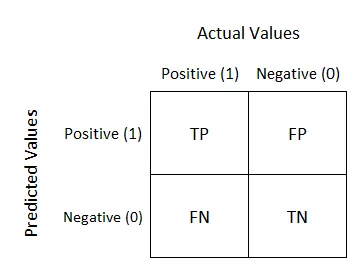
- **Accuracy:** Measures how well the model accurately identifies the samples to their true value
- **Sensitivity/Recall:** Measures how well the model is at detecting true positives
- **Specificity:** Measures how well the model is at avoiding false positives
- **Precision:** Measures the proportion of true positives vs the sum of true positives and false positives

In [982]:
from sklearn import metrics #model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #model performance
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score #Receiver operating characteristic
### confusion matrix to understand how good the model is 
cmatrix = metrics.confusion_matrix(y_train_predict2.StageName, y_train_predict2.Prediction )
print(cmatrix)

[[5325 3160]
 [4202 6614]]


In [983]:
TN = cmatrix[0,0] # true negatives
print("True Negatives", TN)
FP = cmatrix[0,1] # false positives
print("False Positives", FP)
FN = cmatrix[1,0] # false negatives
print("False Negatives", FN)
TP = cmatrix[1,1] # true positive 
print("True Positives", TP)

True Negatives 5325
False Positives 3160
False Negatives 4202
True Positives 6614


In [984]:
accuracy = metrics.accuracy_score(y_train_predict2.StageName, y_train_predict2.Prediction)
#(TN+TP) / (TP+TN+FP+FN)
print("Accuracy", accuracy) #61.86%
 
sensitivity = TP / (TP+FN)
print("Sensitivity", sensitivity) #61.15%
 
specificity = TN/ (TN+FP)
print("Specificity", specificity) #62.76%
 
precision = TP / (TP+FP)
print("Precision", precision) #67.67%

Accuracy 0.6185689860628983
Sensitivity 0.6115014792899408
Specificity 0.6275780789628757
Precision 0.6766932678534888


In [624]:
X_train

,const,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,OpportunityType_Renewal,OpportunityType_Termination,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_9,CreateDateMonth_12
24519,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20245,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5274,1.0,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25876,1.0,0.306204,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13123,1.0,0.119323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,1.0,0.190397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,1.0,0.028988,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10799,1.0,0.271992,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Test Data Set

In [625]:
######apply model to test
 
#match X_test to X_train shape
cols_to_keep = ['CurrentCompanyMarketCap', 'CurrentCompanyMarketCapCategory_Mega', 'CurrentCompanyMarketCapCategory_Micro', 'OpportunityType_Renewal', 'OpportunityType_Termination', 'CreateDateMonth_5', 'CreateDateMonth_6', 'CreateDateMonth_7', 'CreateDateMonth_9', 'CreateDateMonth_12']

X_test = X_test[cols_to_keep]
X_test = sm.add_constant(X_test)

In [626]:
X_test

,const,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,OpportunityType_Renewal,OpportunityType_Termination,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_9,CreateDateMonth_12
20175,1.0,0.190397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6818,1.0,0.453809,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26318,1.0,0.306204,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10929,1.0,0.271992,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5575,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9347,1.0,0.020677,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3928,1.0,0.144637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26640,1.0,0.018135,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1387,1.0,0.000301,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [627]:
#use the final model from the training set to predict
y_test_predic = lm.fit().predict(X_test)
y_test_predic

20175    0.398976
6818     0.468867
26318    0.456995
10929    0.818506
5575     0.513002
           ...   
9347     0.771255
3928     0.395431
26640    0.805984
1387     0.374763
13898    0.816146
Length: 8273, dtype: float64

In [628]:
#compare predicted probability in training set to actual labels in training set
y_test_predic2 = pd.DataFrame({'StageName':y_test.values, 'StageNameProbability':y_test_predic})
y_test_predic2.head()

,StageName,StageNameProbability
20175,1,0.398976
6818,0,0.468867
26318,1,0.456995
10929,1,0.818506
5575,0,0.513002


In [629]:
#label probability at 50%
y_test_predic2['Prediction'] = y_test_predic2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_test_predic2.head()

,StageName,StageNameProbability,Prediction
20175,1,0.398976,0
6818,0,0.468867,0
26318,1,0.456995,0
10929,1,0.818506,1
5575,0,0.513002,1


In [630]:
### confusion matrix to understand how good the model is 
cmatrix2 = metrics.confusion_matrix(y_test_predic2.StageName, y_test_predic2.Prediction )
print(cmatrix2)

[[2311 1355]
 [1860 2747]]


In [631]:
TN2 = cmatrix2[0,0] # true negatives
print("True Negatives", TN2)
FP2 = cmatrix2[0,1] # false positives
print("False Positives", FP2)
FN2 = cmatrix2[1,0] # false negatives
print("False Negatives", FN2)
TP2 = cmatrix2[1,1] # true positive 
print("True Positives", TP2)

True Negatives 2311
False Positives 1355
False Negatives 1860
True Positives 2747


- Looking at the metrics from the training set vs the testing set, the values are close, so the model generalized well and is consistent with new data

In [632]:
accuracy = metrics.accuracy_score(y_test_predic2.StageName, y_test_predic2.Prediction)
#(TN+TP) / (TP+TN+FP+FN)
print("Accuracy", accuracy) #61.86% train -> 61.14% test
 
sensitivity = TP2 / (TP2+FN2)
print("Sensitivity", sensitivity) #61.15% train -> 59.63% test
 
specificity = TN2/ (TN2+FP2)
print("Specificity", specificity) #62.76% train -> 63.04% test
 
precision = TP2 / (TP2+FP2)
print("Precision", precision) #67.67% -> 67.97% test

Accuracy 0.6113864378097426
Sensitivity 0.5962665509008032
Specificity 0.6303873431533006
Precision 0.6696733300828864


### ROC Curve
- Visualizes how well the model predicts `StageName` as opposed to random chance
- The area between the dotted line and the blue line is the 'lift' from random chance
- The total area under the blue curve is the AUC score (AUC of 1 means the model predicts the right outcome 100% of the time)

In [791]:
#set up train variables
fpr, tpr, thresholds = roc_curve(y_train, y_train_predict)
roc_auc = roc_auc_score(y_train, y_train_predict)

In [792]:
#set up test variables
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_test_predic)
roc_auc2 = roc_auc_score(y_test, y_test_predic)

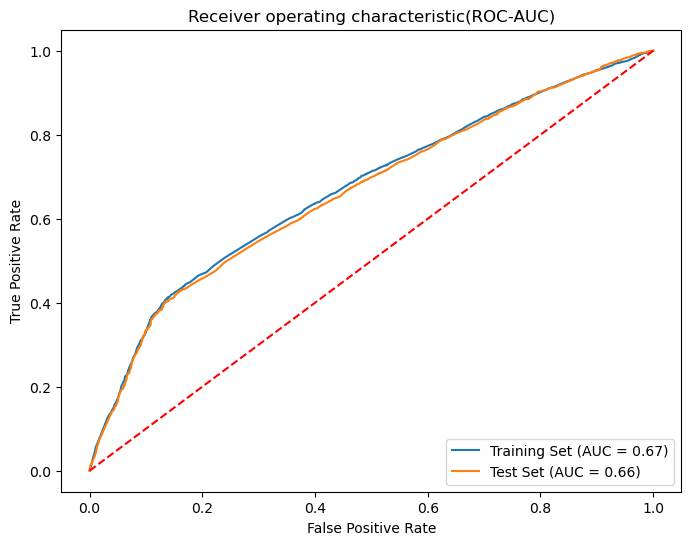

In [793]:
#create figure and subplots for training and test sets
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Training Set (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2,label='Test Set (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC-AUC)')
plt.legend(loc="lower right")
plt.show()

### Problem Statement and Hypothesis
- Research Question: Can the business predict opportunity outcomes?
- Alternate Hypothesis: Yes, we can predict opportunity outcomes
- Null Hypothesis: No, we cannot predict opportunity outcomes

### Summary
- Acceptable accuracy score: 70-90%
- Acceptable AUC score: 70-90%

We fail to reject the null hypothesis and conclude that there is not sufficient evidence to say that we can predict opportunity outcomes. 
The result of the model shows an accuracy and sensitivity of 61%, specificity of 62%, precision of 67%, and an AUC value of .67.

### Limitations
- Not all losses were reported so we did not have enough data for both wins and losses
- There were missing data we filled in with averages and modes
- There could be bias present in the model as we may not know how the data was collected
    - Inconsistent data collection
    - Poor data practices
    - Insufficient data
    - Lack of understanding the raw data gathered

### Recommended Course of Action
- To improve the model, the business should provide more records and gather all the information in the database - including opportunities that were lost. 
- Understand how the data is collected and gain a better understanding of each feature
- Other models should be used to see if there is a better fit, such as KNN, neural networks, decision trees, etc...